# Yolo

Taken from https://github.com/zzh8829/yolov3-tf2

In [ ]:
from fastai.vision import open_image

In [ ]:
import fastai 
print (fastai.__version__)

1.0.61


In [ ]:
import joblib

In [ ]:
!gdown --id 1v1pP3-g4hY61rGKw1Fs6dpecThHVtxuY

Downloading...
From: https://drive.google.com/uc?id=1v1pP3-g4hY61rGKw1Fs6dpecThHVtxuY
To: /content/test.tfrecord
100% 58.3M/58.3M [00:01<00:00, 29.8MB/s]


In [ ]:
#mount google drive and copy path
!cp /content/drive/MyDrive/train.tfrecord .

In [ ]:
!gdown --id 1V25ZDPmOv89iznsUnTvsdL0A90GzESez

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1V25ZDPmOv89iznsUnTvsdL0A90GzESez 



In [ ]:
from absl import logging
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.utils import plot_model
yolo_max_boxes = 100
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]



batch_size =8
size = 416

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            # print("{}/{} {}".format(sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()


def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)


In [ ]:
from absl import flags
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

yolo_max_boxe = 100
yolo_iou_threshold = 0.5
yolo_score_threshold = 0.5
size=416
'''
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416

yolo_anchors = np.array([(15, 15), (24, 24), (27, 73), (36, 36), (52, 52),\
                         (72, 26), (72, 66), (87, 94), (125, 122)],\
                        np.float32) / 512
'''
yolo_anchors = np.array([(14,14), (24,22), (26,71), (35,34), (52,51),\
                         (70,27), (71,65), (87,93), (126,122)],np.float32)/512
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])



def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv



def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv
#yolo_head
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def YoloV3(size, channels, classes, masks=yolo_anchor_masks):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    #channel 1024
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    #channel 512
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    #channel 256
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    return Model(inputs, (output_0, output_1, output_2), name='yolov3')


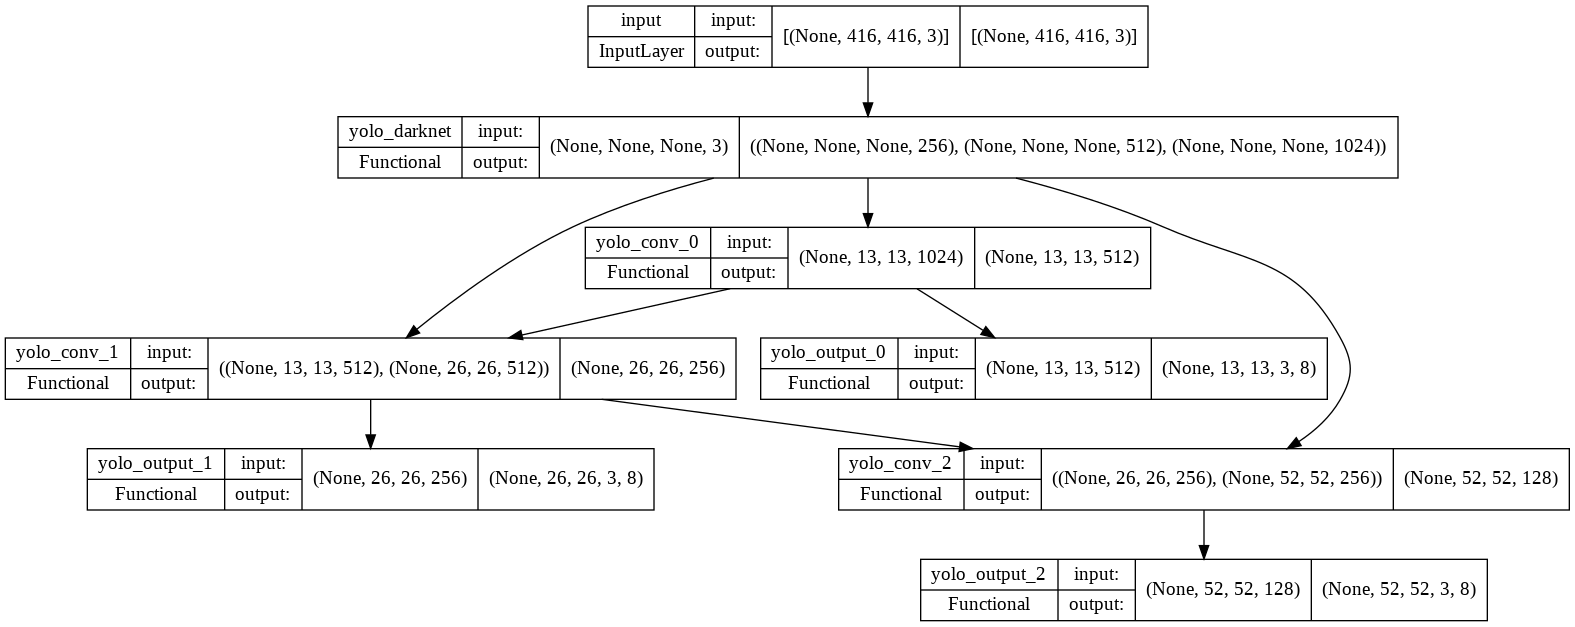

In [ ]:
model = YoloV3(size, 3, 3)
plot_model(model, 'tfmodel.png', show_shapes=True)

In [ ]:
def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1:3] 
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy) 
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)

    pred_box = tf.concat((box_xy, box_wh), axis=-1)  
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))

    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(grid_size, tf.float32) 
    box_wh = anchors * tf.exp(box_wh) 

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) 

    
    return bbox, objectness, class_probs, pred_box

In [ ]:
def broadcast_iou(box_1, box_2):
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)

    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h 
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

def YoloLoss(anchors, classes=3, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2] 
        pred_wh = pred_xywh[..., 2:4] 

        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)

        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]


        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.logical_or(tf.math.is_inf(true_wh),
                                         tf.math.is_nan(true_wh)),
                           tf.zeros_like(true_wh), true_wh)

        obj_mask = tf.squeeze(true_obj, -1) 
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)




# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md#conversion-script-outline-conversion-script-outline
# Commented out fields are not required in our project
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}

def parse_tfrecord(tfrecord, class_table, size):
    #Parses a single Example proto.
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    #Decoding a JPEG-encoded image to a uint8 tensor.
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    print ("x_train=",x_train)
    #Resizing image to fixed side
    x_train = tf.image.resize(x_train, (size, size))

    #Converting a SparseTensor into a dense tensor. and reading object class
    #names
    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)
  
    paddings = [[0, yolo_max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)
    print ("x_train=",x_train)
    print ("y_train=",y_train)

    return x_train, y_train

def load_tfrecord_dataset(file_pattern, class_file, size=size):
    LINE_NUMBER = -1  # TODO: use tf.lookup.TextFileIndex.LINE_NUMBER
    #Creating a generic hash table that is immutable once initialized 
    #For more info vist:
    #https://www.tensorflow.org/api_docs/python/tf/lookup/TextFileInitializer
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter="\n"), -1)

    #creating a dataset of files matching a pattern
    files = tf.data.Dataset.list_files(file_pattern)
    print ("files=",files)
    #Mapping dataset to TFRecordsDataset and used flat_map to make sure that
    #order of dataset stays the same. For more info 
    #visit: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    dataset = files.flat_map(tf.data.TFRecordDataset)
    #Parsing each records of dataset
    print (dataset.map(lambda x: parse_tfrecord(x, class_table, size)))
    return dataset.map(lambda x: parse_tfrecord(x, class_table, size))

def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)



In [ ]:
labels = ['Floating Head Tank\n','Tank\n','Tank Cluster\n']
with open('label.names','w') as fp:
  fp.writelines(labels)

In [ ]:
train_dataset = load_tfrecord_dataset('train.tfrecord', 'label.names')

train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.map(lambda x, y: (
    transform_images(x, size),
    transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

print (train_dataset)

files= <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<MapDataset element_spec=(TensorSpec(shape=(416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 13, 13, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26, 26, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 52, 52, 3, 6), dtype=tf.float32, name=None)))>


In [ ]:
val_dataset = load_tfrecord_dataset('test.tfrecord', 'label.names')
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    transform_images(x, size),
    transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
print(val_dataset)

files= <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<MapDataset element_spec=(TensorSpec(shape=(416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<MapDataset element_spec=(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 13, 13, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26, 26, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 52, 52, 3, 6), dtype=tf.float32, name=None)))>


In [ ]:
!cp /content/drive/MyDrive/yolov3.weights .

In [ ]:
!gdown --id 1Bc8LoqGxYsJLOxwFVHvryrvqlqufIxs0

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Bc8LoqGxYsJLOxwFVHvryrvqlqufIxs0 



In [ ]:
from absl import app, flags, logging
from absl.flags import FLAGS

import tensorflow as tf
import numpy as np
import cv2
import time
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

#from yolov3_tf2.utils import freeze_all
#import yolov3_tf2.dataset as dataset

learning_rate = 1e-3
def setup_model():
    ############################# TODO remove dep
    # load pretrained weight
    # https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
    pre_model = YoloV3(size,3, classes=80)
    load_darknet_weights(pre_model,'/content/yolov3.weights')
    model = YoloV3(size,3, classes=3)
    model.get_layer('yolo_darknet').set_weights(
        pre_model.get_layer('yolo_darknet').get_weights())
    freeze_all(model.get_layer('yolo_darknet'))
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = [YoloLoss(anchors[mask], classes=3)
            for mask in anchor_masks]

    model.compile(optimizer=optimizer, loss=loss)

    return model, optimizer, loss, anchors, anchor_masks

model, optimizer, loss, anchors, anchor_masks = setup_model()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    # If we only have one class, do not multiply by class_prob (always 0.5)
    if classes == 1:
        scores = confidence
    else:
        scores = confidence * class_probs

    dscores = tf.squeeze(scores, axis=0)
    scores = tf.reduce_max(dscores,[1])
    bbox = tf.reshape(bbox,(-1,4))
    classes = tf.argmax(dscores,1)
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        boxes=bbox,
        scores=scores,
        max_output_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold,
        soft_nms_sigma=0.5
    )
    
    num_valid_nms_boxes = tf.shape(selected_indices)[0]

    selected_indices = tf.concat([selected_indices,tf.zeros(yolo_max_boxes-num_valid_nms_boxes, tf.int32)], 0)
    selected_scores = tf.concat([selected_scores,tf.zeros(yolo_max_boxes-num_valid_nms_boxes,tf.float32)], -1)

    boxes=tf.gather(bbox, selected_indices)
    boxes = tf.expand_dims(boxes, axis=0)
    scores=selected_scores
    scores = tf.expand_dims(scores, axis=0)
    classes = tf.gather(classes,selected_indices)
    classes = tf.expand_dims(classes, axis=0)
    valid_detections=num_valid_nms_boxes
    valid_detections = tf.expand_dims(valid_detections, axis=0)

    return boxes, scores, classes, valid_detections



In [ ]:
def detect(image,index=0):
  class_names= { 0:'Floating Head Tank', 1:'Tank Cluster',2:'Tank'}
  img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, size)
  res = model.predict(img)
  total_class = len(class_names.values())
  boxes_0 =  yolo_boxes(res[0], yolo_anchors[yolo_anchor_masks[0]], classes=total_class)
  boxes_1 =  yolo_boxes(res[1], yolo_anchors[yolo_anchor_masks[1]], classes=total_class)
  boxes_2 = yolo_boxes(res[2], yolo_anchors[yolo_anchor_masks[2]], classes=total_class)

  outputs = yolo_nms((boxes_0[:3], boxes_1[:3], boxes_2[:3]), yolo_anchors, yolo_anchor_masks, classes=total_class)
  boxes, scores, classes, nums = outputs
  return outputs

# Volume Estimation

In [ ]:
!cp  '/content/drive/MyDrive/Oil Tanks.zip' .

In [ ]:
!gdown --id 1JA5YtBcL2462ekmyHxZcyj6Y6m3aiKt1

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1JA5YtBcL2462ekmyHxZcyj6Y6m3aiKt1 



In [ ]:
!unzip  'Oil Tanks.zip'


In [ ]:
!mv 'Oil Tanks' 'oil'

Converting each large image into 10 X 10 image , large image is having dimension of 4800 X 4800 we want to break into 512 X 512 dimension , we need to have a overlap of 37 pixels.We will be storing only full head-tank, to know that 

In [ ]:
# https://stackoverflow.com/questions/22685274/divide-an-image-into-5x5-blocks-in-python-and-compute-histogram-for-each-block
import os
import cv2
def convert_to_smaller_patches(filename,to_be_stored):
  img = cv2.imread(filename)
  imgh, imgw, _ = img.shape
  print ("imgh=",imgh)
  print ("imgw=",imgw)

  resize = 512
  overlap = 37
  frmt = '.jpg'
  stored_file = os.path.basename(filename.rsplit('.jpg')[0])
  curr_dir = os.getcwd()
  print (curr_dir)
  os.chdir(to_be_stored)
  print ("current_dir=",os.getcwd())
  size = resize - overlap
  for row,i in enumerate(range(0,imgh-resize+1,size)):
    for col,j in enumerate(range(0,imgw-resize+1,size)):
        print ("row=",row)
        print ("col=",col)
        split = img[i:i+resize, j:j+resize]
        print (stored_file)
        cv2.imwrite('{}_{}_{}.{}'.format(stored_file,row,col, frmt), split)
  
  os.chdir(curr_dir)


In [ ]:
!rm -rf small_path

In [ ]:
!mkdir small_path

In [ ]:
large_image = '/content/oil/large_images'
for i in os.listdir(large_image):
  comp_path = os.path.join(large_image,i)
  convert_to_smaller_patches(comp_path,'small_path')

In [ ]:
!cp  /content/drive/MyDrive/latest.hdf5 .

In [ ]:
!gdown --id 1c5iwHnpI58s4ORGsXEiaOs-leB7ZeNcp

In [ ]:
model.load_weights('latest.hdf5')

**Predict the floating head Tank images and store them**

In [ ]:
import pandas as pd

In [ ]:
def predict_floating_head_tank():
  image_name = []
  bb_box = []
  image_folder = '/content/small_path/'
  class_names  = { 0:'Floating Head Tank', 1:'Tank Cluster',2:'Tank'}
  for files in os.listdir(image_folder):
    image  = os.path.join(image_folder,files)
    output = detect(image)
    img    = cv2.imread(image)
    # as seen from the output , shown in detect function
    boxes, scores, classes, nums = output
    bounding_box = []
    boxes, scores, classes, nums = boxes[0], scores[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
      x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
      x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
      if str(class_names[int(classes[i])])== 'Floating Head Tank':
          print ()
          print ("x1y1=",x1y1)
          bounding_box.append([x1y1[1],x1y1[0],x2y2[1],x2y2[0]])
          image_name.append(image)
          bb_box.append(bounding_box)  
  return image_name,bb_box
im,bb = predict_floating_head_tank()  
df = pd.DataFrame()
df['image_name']     =  im
df['bounding_box']   =  bb

In [ ]:
df.to_csv('fht.csv')

In [ ]:
df

,image_name,bounding_box
0,/content/small_path/02_large_5_5..jpg,"[[102, 386, 165, 458]]"
1,/content/small_path/43_large_3_8..jpg,"[[291, 113, 413, 247], [43, 1, 157, 63]]"
2,/content/small_path/43_large_3_8..jpg,"[[291, 113, 413, 247], [43, 1, 157, 63]]"
3,/content/small_path/93_large_6_0..jpg,"[[22, 177, 59, 218], [2, 207, 17, 270]]"
4,/content/small_path/93_large_6_0..jpg,"[[22, 177, 59, 218], [2, 207, 17, 270]]"
...,...,...
4835,/content/small_path/76_large_2_4..jpg,"[[98, 263, 134, 304], [129, 228, 161, 264], [3..."
4836,/content/small_path/76_large_2_4..jpg,"[[98, 263, 134, 304], [129, 228, 161, 264], [3..."
4837,/content/small_path/76_large_2_4..jpg,"[[98, 263, 134, 304], [129, 228, 161, 264], [3..."
4838,/content/small_path/76_large_2_4..jpg,"[[98, 263, 134, 304], [129, 228, 161, 264], [3..."


In [ ]:
!cp /content/drive/MyDrive/fht.csv .

In [ ]:
import pandas as pd
df = pd.read_csv('fht.csv')

In [ ]:
df1=df.drop_duplicates(subset=['image_name'])

In [ ]:
df1

,Unnamed: 0,image_name,bounding_box
0,0,/content/small_path/02_large_5_5..jpg,"[[102, 386, 165, 458]]"
1,1,/content/small_path/43_large_3_8..jpg,"[[291, 113, 413, 247], [43, 1, 157, 63]]"
3,3,/content/small_path/93_large_6_0..jpg,"[[22, 177, 59, 218], [2, 207, 17, 270]]"
5,5,/content/small_path/44_large_3_5..jpg,"[[360, 246, 471, 347]]"
6,6,/content/small_path/98_large_5_3..jpg,"[[1, 396, 116, 507], [364, 419, 466, 510], [16..."
...,...,...,...
4816,4816,/content/small_path/89_large_2_1..jpg,"[[95, 151, 165, 224], [153, 263, 234, 342], [2..."
4819,4819,/content/small_path/33_large_2_5..jpg,"[[181, 163, 218, 201], [144, 274, 213, 340], [..."
4822,4822,/content/small_path/45_large_2_2..jpg,"[[0, 385, 27, 425], [0, 327, 25, 365]]"
4824,4824,/content/small_path/25_large_6_7..jpg,"[[348, 274, 400, 323]]"


In [ ]:
import ast
image=[]
bb = []
df1['bounding_box']=df1['bounding_box'].apply(ast.literal_eval)
for index,row in df1.iterrows():
   for val in  row['bounding_box']:
     bb.append(val)
     image.append(row['image_name'])

print (image[:20])
print (bb[:20])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


['/content/small_path/02_large_5_5..jpg', '/content/small_path/43_large_3_8..jpg', '/content/small_path/43_large_3_8..jpg', '/content/small_path/93_large_6_0..jpg', '/content/small_path/93_large_6_0..jpg', '/content/small_path/44_large_3_5..jpg', '/content/small_path/98_large_5_3..jpg', '/content/small_path/98_large_5_3..jpg', '/content/small_path/98_large_5_3..jpg', '/content/small_path/56_large_3_9..jpg', '/content/small_path/56_large_3_9..jpg', '/content/small_path/28_large_8_4..jpg', '/content/small_path/28_large_8_4..jpg', '/content/small_path/43_large_4_2..jpg', '/content/small_path/43_large_4_2..jpg', '/content/small_path/31_large_7_8..jpg', '/content/small_path/31_large_7_8..jpg', '/content/small_path/21_large_8_3..jpg', '/content/small_path/11_large_5_2..jpg', '/content/small_path/11_large_5_2..jpg']
[[102, 386, 165, 458], [291, 113, 413, 247], [43, 1, 157, 63], [22, 177, 59, 218], [2, 207, 17, 270], [360, 246, 471, 347], [1, 396, 116, 507], [364, 419, 466, 510], [162, 489, 24

In [ ]:
df2 = pd.DataFrame()
df2['image_path']=image
df2['bounding_box']=bb

In [ ]:
df2

,image_path,bounding_box
0,/content/small_path/02_large_5_5..jpg,"[102, 386, 165, 458]"
1,/content/small_path/43_large_3_8..jpg,"[291, 113, 413, 247]"
2,/content/small_path/43_large_3_8..jpg,"[43, 1, 157, 63]"
3,/content/small_path/93_large_6_0..jpg,"[22, 177, 59, 218]"
4,/content/small_path/93_large_6_0..jpg,"[2, 207, 17, 270]"
...,...,...
4835,/content/small_path/76_large_2_4..jpg,"[358, 10, 394, 47]"
4836,/content/small_path/76_large_2_4..jpg,"[156, 195, 191, 230]"
4837,/content/small_path/76_large_2_4..jpg,"[94, 259, 137, 307]"
4838,/content/small_path/76_large_2_4..jpg,"[395, 51, 425, 81]"


Taken from https://github.com/kheyer/Oil-Tank-Volume-Estimation

In [ ]:
from fastai.vision import open_image

In [ ]:
def crop_image(row,factor_x=0.5,factor_y=0.6):
        image = row['image_path']
        image = open_image(image)
        gt_coords = row['bounding_box'] # bounding box coordinates
        y_min, x_min, y_max, x_max = gt_coords
        
        # scale for tank cropping
        margin_x = int((x_max-x_min)*factor_x)
        margin_y = int((y_max-y_min)*factor_y)

        # y_min, y_max, x_min, x_max values for cropping
        y_min = max(y_min - margin_y, 0)
        y_max = max(y_max + int(margin_y//2), 0)
        x_min = max(x_min - margin_x, 0)
        x_max = max(x_max + margin_x, 0)
        
        # actual margins, given that the calculated margin might extend beyond the image
        margin_y_true = y_min - y_min
        margin_x_true = x_min - x_min
        
        # coordinates of the actual bounding box relative to the crop box
        bbox_relative = [margin_y_true, margin_x_true, (y_max-y_min)+margin_y_true, (x_max-x_min)+margin_x_true]

        # crop section of the image
        tank_crop = image.data[:, y_min:y_max, x_min:x_max].permute(1,2,0).numpy()

        return tank_crop,bbox_relative
        

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

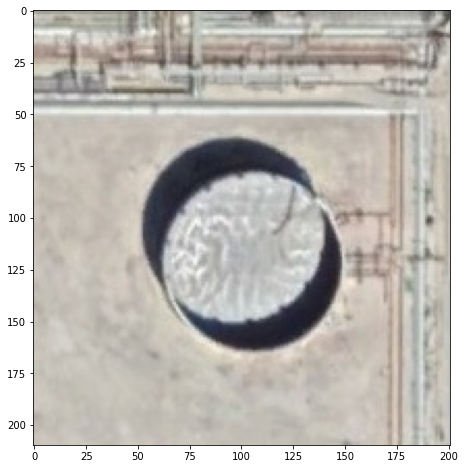

In [ ]:
tank_crop,bbox_relative = crop_image(df2.iloc[5])
fig, axes = plt.subplots(figsize=(8,8))
axes.imshow(tank_crop)

In [ ]:
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import color

In [ ]:
hsv = color.rgb2hsv(tank_crop)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

lab = color.rgb2lab(tank_crop)
l1 = lab[:,:,0]
l2 = lab[:,:,1]
l3 = lab[:,:,2]

These are the channels from the converted images. Note which channels show a strong contrast between shadow regions and non-shadow regions 

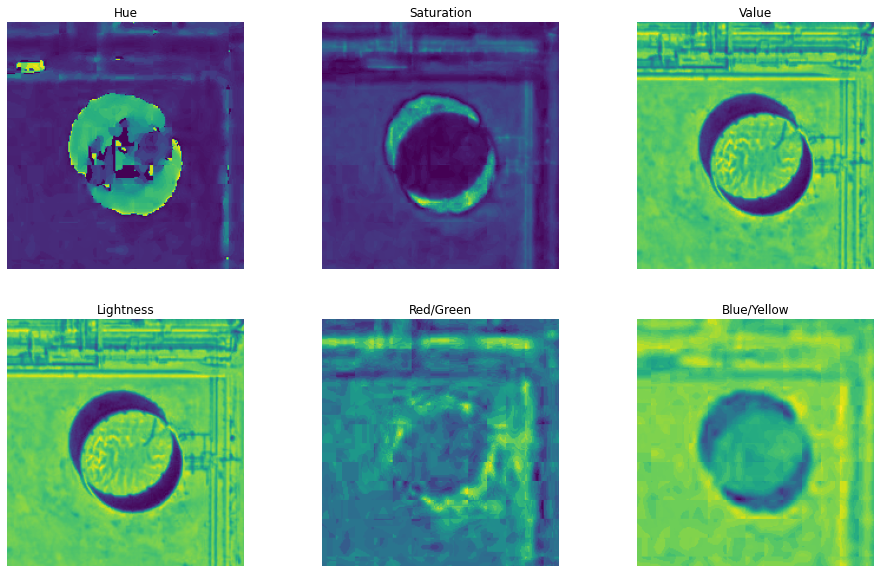

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0][0].imshow(H)
axes[0][0].set_title('Hue')

axes[0][1].imshow(S)
axes[0][1].set_title('Saturation')

axes[0][2].imshow(V)
axes[0][2].set_title('Value')

axes[1][0].imshow(l1)
axes[1][0].set_title('Lightness')

axes[1][1].imshow(l2)
axes[1][1].set_title('Red/Green')

axes[1][2].imshow(l3)
axes[1][2].set_title('Blue/Yellow');

for ax in axes.flat:
    ax.axis('off')

Many methods have been proposed for ratioing these channels to enhance shadows. The NSVDI algorithm proposes $\frac{S-V}{S+V}$. The paper [Estimating the Volume of Oil Tanks Based on High-Resolution Remote Sensing](https://www.mdpi.com/2072-4292/11/7/793/pdf) which explicitly deals with oil tanks suggests $\frac{H+1}{V+1}$.

I found the $\frac{H+1}{V+1}$ was thrown off by strong artifacts in the H channel, likely due to the source images being RGB jpeg images saved from Google Earth rather than real high resolution satellite photography. The $\frac{S-V}{S+V}$ method worked well on some images but failed on others.

Experimentally I found the ratio $\frac{-(l1 + l3)}{V + 1}$ worked well, where $l1$ and $l3$ are the first and third channels of the LAB color space image.

In [ ]:
c1 = (H+1)/(V+1)
c2 = (S-V)/(S+V)
c3 = -(l1+l3)/(V+1)

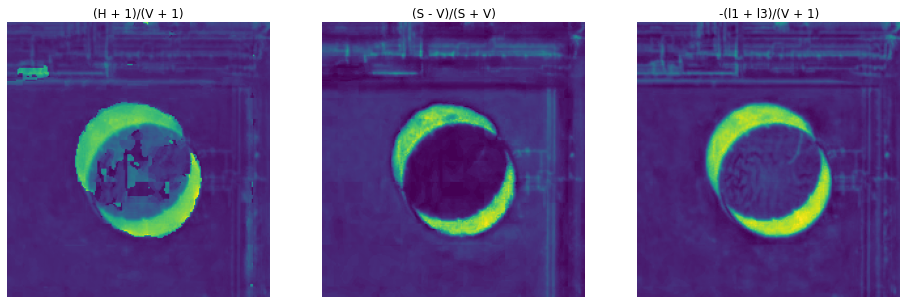

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(c1)
axes[0].set_title('(H + 1)/(V + 1)')
axes[1].imshow(c2)
axes[1].set_title('(S - V)/(S + V)')
axes[2].imshow(c3)
axes[2].set_title('-(l1 + l3)/(V + 1)');

for ax in axes.flat:
    ax.axis('off')

The enhanced image is filtered by thresholding. I found the minimum threshold was often too stringent, while the mean threshold was too permissive. a combination of `0.5 *threshold_minimum  + 0.4 * mean_threshold` works well

In [ ]:
t1 = filters.threshold_minimum(c3)
t2 = filters.threshold_mean(c3)

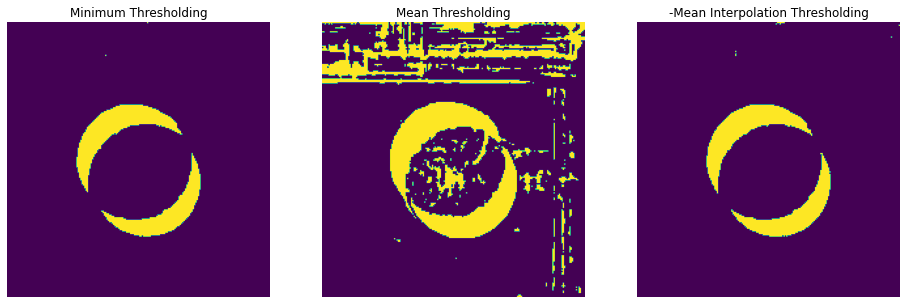

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(c3 > t1)
axes[0].set_title('Minimum Thresholding')
axes[1].imshow(c3 > t2)
axes[1].set_title('Mean Thresholding')
axes[2].imshow(c3 > (0.2*t1 + 0.5*t2))
axes[2].set_title('-Mean Interpolation Thresholding')

for ax in axes.flat:
    ax.axis('off')

The thresholded image is then processed with morphological operations. These operations are:

* 1. Hessian Filter - cleans up noise and line artifacts from white pipes which appear in many images
* 2. Clear Border - clears contours from surrounding tanks
* 3. Morphological Closing - helps separate shapes
* 4. Area Closing - fills small holes
* 5. Morphological Labeling - labels features

In [ ]:
tank_thresh = c3 > (0.2*t1 + 0.5*t2)

label_1 = filters.hessian(tank_thresh)
label_2 = segmentation.clear_border(filters.hessian(tank_thresh))
label_3 = morphology.closing(segmentation.clear_border(filters.hessian(tank_thresh)))
label_4 = morphology.area_closing(morphology.closing(segmentation.clear_border(filters.hessian(tank_thresh))))
label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(tank_thresh)))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the ol

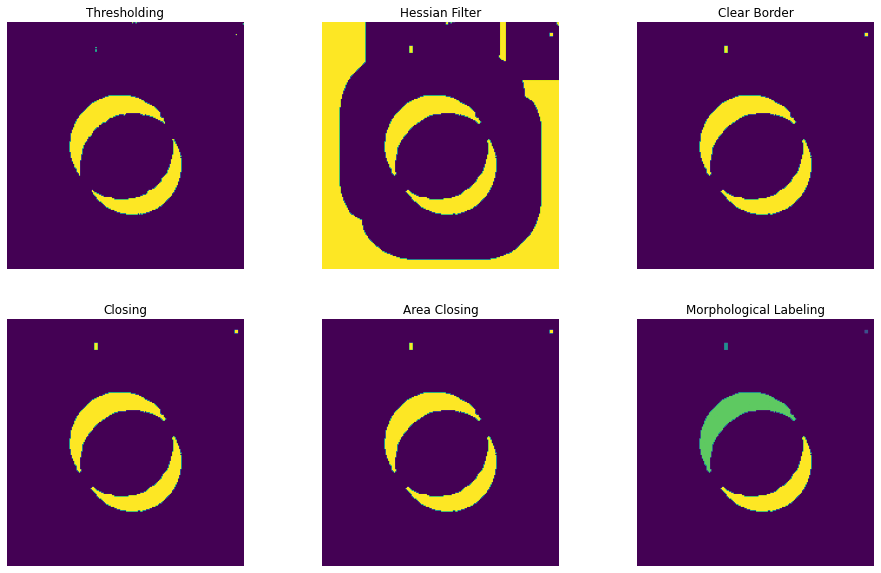

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0][0].imshow(tank_thresh)
axes[0][0].set_title('Thresholding')
axes[0][1].imshow(label_1)
axes[0][1].set_title('Hessian Filter')
axes[0][2].imshow(label_2)
axes[0][2].set_title('Clear Border')
axes[1][0].imshow(label_3)
axes[1][0].set_title('Closing')
axes[1][1].imshow(label_4)
axes[1][1].set_title('Area Closing')
axes[1][2].imshow(label_image)
axes[1][2].set_title('Morphological Labeling')

for ax in axes.flat:
    ax.axis('off')

In [ ]:
def intersection(bb1, bb2):
    '''
    Intersection between two bounding boxes
    '''
    y_min1, x_min1, y_max1, x_max1 = bb1
    y_min2, x_min2, y_max2, x_max2 = bb2
    
    x_left = max(x_min1, x_min2)
    x_right = min(x_max1, x_max2)
    y_top = max(y_min1, y_min2)
    y_bottom = min(y_max1, y_max2)

    intersection = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top+1)
    return intersection

In [ ]:
regions_all = measure.regionprops(label_image)
regions = []

for region in regions_all:
    if intersection(bbox_relative, region.bbox) > 300:
        if region.area > 25:
            b = region.bbox
            if abs(tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                regions.append(region)

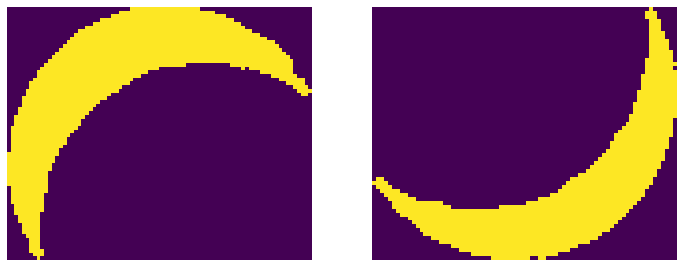

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(regions[0].image)
axes[1].imshow(regions[1].image)
for ax in axes.flat:
    ax.axis('off')

In [ ]:
import numpy as np
areas = np.array([i.area for i in regions])
idx2, idx1 = areas.argsort()[-2:]
volume = 1 - regions[idx2].area / regions[idx1].area
print(volume)

0.2031454783748362


In [ ]:
def conv_bbox(box_dict):
    '''
    `conv_bbox` converts bounding boxes from corner coordinates to a 
    `[y_min, x_min, y_max, x_max]` format
    '''
    xs = np.array(list(set([i['x'] for i in box_dict])))
    ys = np.array(list(set([i['y'] for i in box_dict])))
    
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    
    return y_min, x_min, y_max, x_max

def check_bb(bbox, shape):
        '''
        The algorithm is designed to work with tanks that are fully in frame. 
        Bounding boxes that reach the edge of an image (
          indicating the tank extends beyond the image) 
          are excluded from processing.
        '''
        c, h, w = shape
        
        for d in bbox:
            if d['x'] <= 2 or d['x'] >= w-2:
                return False
            elif d['y'] <=2 or d['y'] >= h-2:
                return False

        return True 



class Tank():
    def __init__(self, box_dict, image, factor_x=0.5, factor_y=0.6):
        
        self.image = image
        self.gt_coords = box_dict # bounding box coordinates
        y_min, x_min, y_max, x_max = self.gt_coords
        
        # scale for tank cropping
        margin_x = int((x_max-x_min)*factor_x)
        margin_y = int((y_max-y_min)*factor_y)

        # y_min, y_max, x_min, x_max values for cropping
        self.y_min = max(y_min - margin_y, 0)
        self.y_max = max(y_max + int(margin_y//2), 0)
        self.x_min = max(x_min - margin_x, 0)
        self.x_max = max(x_max + margin_x, 0)
        
        # actual margins, given that the calculated margin might extend beyond the image
        margin_y_true = y_min - self.y_min
        margin_x_true = x_min - self.x_min
        
        # coordinates of the actual bounding box relative to the crop box
        self.bbox_relative = [margin_y_true, margin_x_true, (y_max-y_min)+margin_y_true, (x_max-x_min)+margin_x_true]

        # crop section of the image
        self.tank_crop = self.image.data[:, self.y_min:self.y_max, self.x_min:self.x_max].permute(1,2,0).numpy()
        
        self.proc_tank()
        self.get_regions()
        
    def proc_tank(self):
        # HSV conversion
        hsv = color.rgb2hsv(self.tank_crop)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
        
        # LAB conversion
        lab = color.rgb2lab(self.tank_crop)
        l1 = lab[:,:,0]
        l2 = lab[:,:,1]
        l3 = lab[:,:,2]
        
        # Enhanced image
        self.tank_hsv = -(l1+l3)/(V+1)
        
        # Threshold values
        t1 = filters.threshold_minimum(self.tank_hsv)
        t2 = filters.threshold_mean(self.tank_hsv)
        
        # Thresholding
        self.tank_thresh = self.tank_hsv > (0.3*t1 + 0.5*t2)
        
        # Processed, labeled image
        self.label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(self.tank_thresh)))))
        
    def get_regions(self):
        # Regions within image
        self.regions_all = measure.regionprops(self.label_image)
        
        self.regions = []
        
        # Some regions are noise. This ensures that regions have a decent area ( > 25 px),
        # that the region intersects the boudning box around the tank (removes lots of noisy features)
        # and that the processed region is also present in the thresholded image (the hessian filter can sometimes 
        # add artifacts that need to be removed this day)
        for region in self.regions_all:
            if intersection(self.bbox_relative, region.bbox) > 300:
                if region.area > 25:
                    b = region.bbox
                    if abs(self.tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                        self.regions.append(region)
                            
        # areas of all regions
        areas = np.array([i.area for i in self.regions])
        
        # if there are more than two areas found, take the two largest
        # 1 - ratio of the two largest areas calculates the volume estimation
        if len(areas) > 1:
            idx2, idx1 = areas.argsort()[-2:]
            self.volume = 1 - self.regions[idx2].area / self.regions[idx1].area
        # if only 1 area is found, tank is assumed to be full
        else:
            idx2 = 0
            idx1 = 0
            self.volume = 1
        
        # Blank image onto which to paste only the two shadow regions
        self.blank = np.zeros(self.tank_crop.shape[:2])
        
        for region in [self.regions[idx1], self.regions[idx2]]:
            y_min, x_min, y_max, x_max = region.bbox
            self.blank[y_min:y_max, x_min:x_max] += region.image.astype('uint8')
                        
        # get contours of shadows
        self.contours = measure.find_contours(self.blank, 0.5)
        if len(self.contours) > 1:
            # If there are multiple contours, take the two longest
            contour_idxs = np.array([len(i) for i in self.contours]).argsort()[-2:]
        else:
            contour_idxs = [0]
        self.contours_select = [self.contours[i] for i in contour_idxs]            
    
    def plot_tank(self):
        fig, axes = plt.subplots(3,3, figsize=(12,12))

        fig.suptitle('Tank Volume {:.3f}%'.format(self.volume*100))

        axes[0][0].imshow(self.tank_crop)
        axes[0][0].set_title('Tank Crop')

        axes[0][1].imshow(self.tank_crop)
        axes[0][1].imshow(self.blank, alpha=0.5)
        axes[0][1].set_title('Shadow Overlay')

        axes[0][2].imshow(self.tank_crop)
        for cnt in self.contours_select:
            axes[0][2].plot(cnt[:,1], cnt[:,0])
        axes[0][2].set_title('Shadow Contour')

        axes[1][0].imshow(self.blank)
        axes[1][0].set_title('Shadow')

        axes[1][1].imshow(np.zeros(self.blank.shape))
        for cnt in self.contours:
            axes[1][1].plot(cnt[:,1], cnt[:,0])
        axes[1][1].set_title('All Contours')

        axes[1][2].imshow(np.zeros(self.blank.shape))
        for cnt in self.contours_select:
            axes[1][2].plot(cnt[:,1], cnt[:,0])
        axes[1][2].set_title('Major Contours')

        axes[2][0].imshow(self.tank_hsv)
        axes[2][0].set_title('HSV Ratio')

        axes[2][1].imshow(self.tank_thresh)
        axes[2][1].set_title('Tank Thresholding')

        axes[2][2].imshow(self.label_image)
        axes[2][2].set_title('Morphology Labeling')

        for ax in axes.flat:
            ax.axis('off')


In [ ]:
image_path = df2.iloc[0]['image_path']
box_dict = df2.iloc[0]['bounding_box']
print (type(box_dict[0]))
img = open_image(image_path)
obj = Tank(box_dict,img)

<class 'int'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


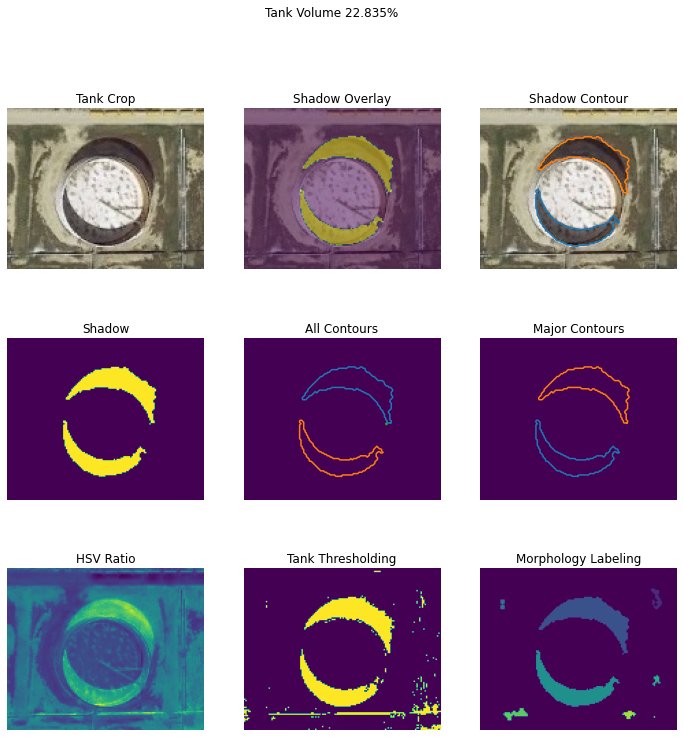

In [ ]:
obj.plot_tank()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


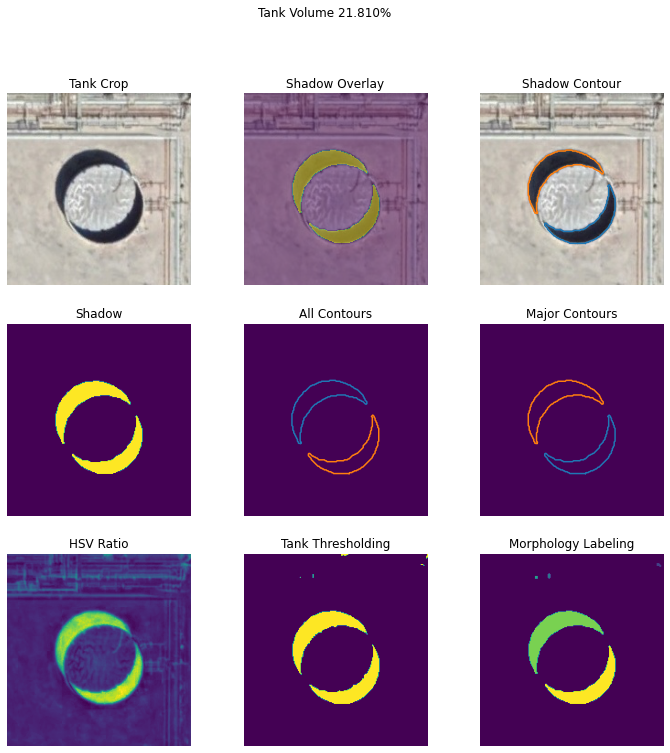

In [ ]:
image_path = df2.iloc[5]['image_path']
box_dict = df2.iloc[5]['bounding_box']
img = open_image(image_path)
obj1 = Tank(box_dict,img)
obj1.plot_tank()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


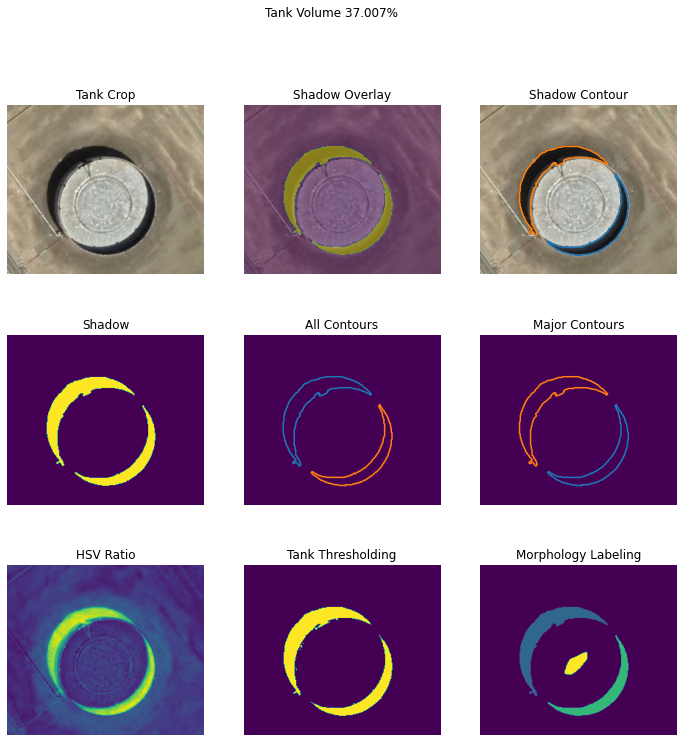

In [ ]:
image_path = df2.iloc[1]['image_path']
box_dict = df2.iloc[1]['bounding_box']
img = open_image(image_path)
obj1 = Tank(box_dict,img)
obj1.plot_tank()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


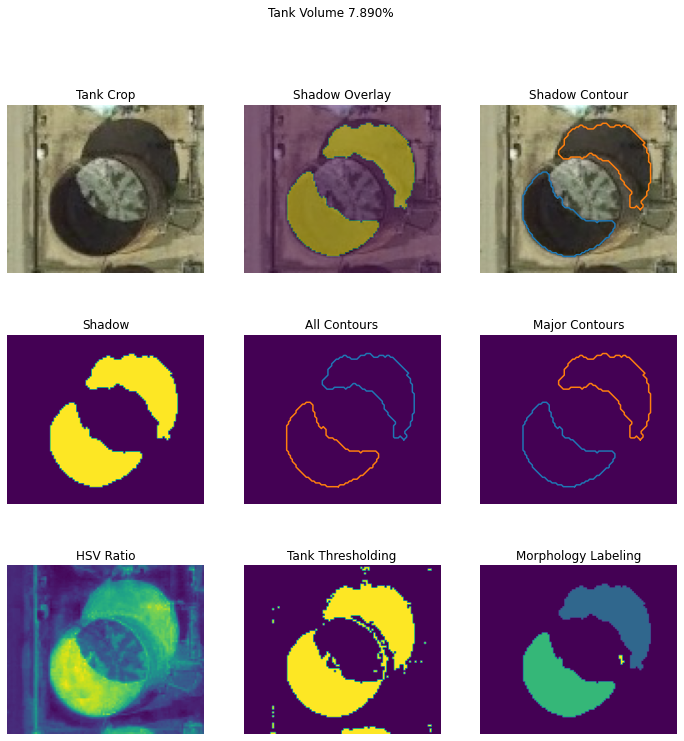

In [ ]:
image_path = df2.iloc[18]['image_path']
box_dict = df2.iloc[18]['bounding_box']
img = open_image(image_path)
obj1 = Tank(box_dict,img)
obj1.plot_tank()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.


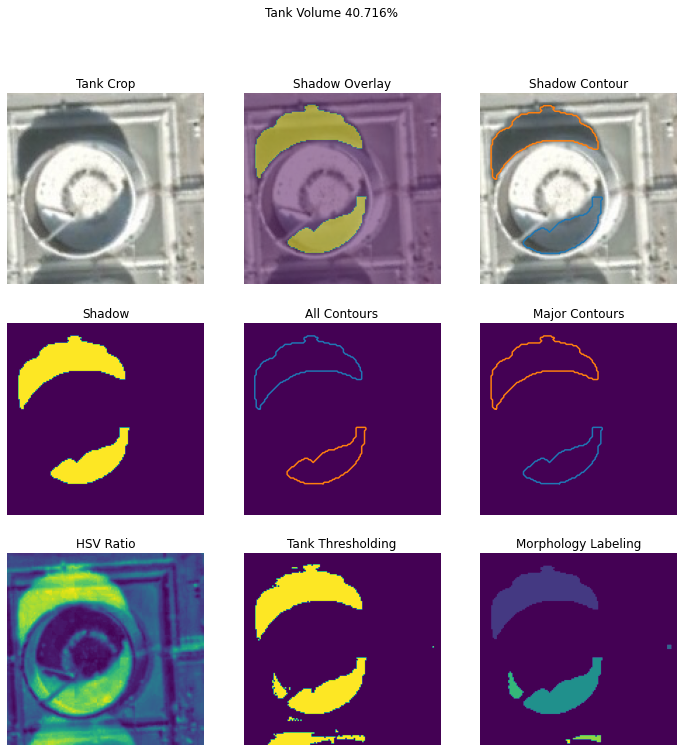

In [ ]:
image_path = df2.iloc[35]['image_path']
box_dict = df2.iloc[35]['bounding_box']
img = open_image(image_path)
obj1 = Tank(box_dict,img)
obj1.plot_tank()